# --> Importations

In [333]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import tensorflow as tf
import os
from glob import glob

from sklearn.model_selection import train_test_split
from keras.preprocessing.image import ImageDataGenerator


# for dirname, _, filenames in os.walk("/kaggle/input"):
#     for filename in filenames:
#         print(os.path.join(dirname, filename))

# ToDoList

- Preprocess CSV file
- Preprocess images
- Build CNN model for images trained on labels
- Make the CNN model return a probability vector
- Use a MLP model to add table features with this probabilty vector
- Tune both models

# Infos

- I will start with simple model and preprocessing, not trying to create visual border around the disease
- I won"t use some of the table features at the beginning

# Global variables

In [334]:
DATA_ENTRY_CSV_PATH = "../input/data/Data_Entry_2017.csv"
IMG_SIZE = (128, 128)
VALID_SET_PERCENT = 0.2
#LABELS
#N_LABELS
#ONE_HOT_LABELS

# Preprocess CSV file

In [335]:
data_entry_df = pd.read_csv(DATA_ENTRY_CSV_PATH)
all_image_paths = {os.path.basename(x): x for x in glob(os.path.join("..", "input", "data", "images*", "*", "*.png"))}
print("Images found:", len(all_image_paths), ", Total headers", data_entry_df.shape[0])
data_entry_df["path"] = data_entry_df["Image Index"].map(all_image_paths.get)
# data_entry_df["Patient Age"] = data_entry_df["Patient Age"].map(lambda x: int(x[:-1]))
data_entry_df.sample(3)

Images found: 112120 , Total headers 112120


,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,OriginalImage[Width,Height],OriginalImagePixelSpacing[x,y],Unnamed: 11,path
92915,00023184_000.png,Pleural_Thickening,0,23184,52,F,PA,3056,2544,0.139000,0.139000,NaN,../input/data/images_010/images/00023184_000.png
99795,00026432_002.png,Pleural_Thickening,2,26432,71,M,PA,2992,2991,0.143000,0.143000,NaN,../input/data/images_011/images/00026432_002.png
110864,00030223_000.png,No Finding,0,30223,51,F,PA,2021,2021,0.194311,0.194311,NaN,../input/data/images_012/images/00030223_000.png


In [336]:
data_entry_df

,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,OriginalImage[Width,Height],OriginalImagePixelSpacing[x,y],Unnamed: 11,path
0,00000001_000.png,Cardiomegaly,0,1,58,M,PA,2682,2749,0.143,0.143,NaN,../input/data/images_001/images/00000001_000.png
1,00000001_001.png,Cardiomegaly|Emphysema,1,1,58,M,PA,2894,2729,0.143,0.143,NaN,../input/data/images_001/images/00000001_001.png
2,00000001_002.png,Cardiomegaly|Effusion,2,1,58,M,PA,2500,2048,0.168,0.168,NaN,../input/data/images_001/images/00000001_002.png
3,00000002_000.png,No Finding,0,2,81,M,PA,2500,2048,0.171,0.171,NaN,../input/data/images_001/images/00000002_000.png
4,00000003_000.png,Hernia,0,3,81,F,PA,2582,2991,0.143,0.143,NaN,../input/data/images_001/images/00000003_000.png
...,...,...,...,...,...,...,...,...,...,...,...,...,...
112115,00030801_001.png,Mass|Pneumonia,1,30801,39,M,PA,2048,2500,0.168,0.168,NaN,../input/data/images_012/images/00030801_001.png
112116,00030802_000.png,No Finding,0,30802,29,M,PA,2048,2500,0.168,0.168,NaN,../input/data/images_012/images/00030802_000.png
112117,00030803_000.png,No Finding,0,30803,42,F,PA,2048,2500,0.168,0.168,NaN,../input/data/images_012/images/00030803_000.png
112118,00030804_000.png,No Finding,0,30804,30,F,PA,2048,2500,0.168,0.168,NaN,../input/data/images_012/images/00030804_000.png


In [337]:
data_entry_df.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
Follow-up #,112120.0,8.573751,15.406320,0.000,0.000,3.000,10.000,183.0000
Patient ID,112120.0,14346.381743,8403.876972,1.000,7310.750,13993.000,20673.000,30805.0000
Patient Age,112120.0,46.901463,16.839923,1.000,35.000,49.000,59.000,414.0000
OriginalImage[Width,112120.0,2646.078844,341.246429,1143.000,2500.000,2518.000,2992.000,3827.0000
Height],112120.0,2486.438842,401.268227,966.000,2048.000,2544.000,2991.000,4715.0000
OriginalImagePixelSpacing[x,112120.0,0.155649,0.016174,0.115,0.143,0.143,0.168,0.1988
y],112120.0,0.155649,0.016174,0.115,0.143,0.143,0.168,0.1988
Unnamed: 11,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN


# --> Get labels and number of labels

In [338]:
LABELS = []
for label in data_entry_df["Finding Labels"].unique():
    for word in label.split("|"):
        if word not in LABELS:
            LABELS.append(word)
N_LABELS = len(LABELS)
print("Number of labels :", N_LABELS)
print("Labels : ", LABELS)

Number of labels : 15
Labels :  ['Cardiomegaly', 'Emphysema', 'Effusion', 'No Finding', 'Hernia', 'Infiltration', 'Mass', 'Nodule', 'Atelectasis', 'Pneumothorax', 'Pleural_Thickening', 'Pneumonia', 'Fibrosis', 'Edema', 'Consolidation']


In [339]:
data_entry_df["Finding Labels"] = data_entry_df["Finding Labels"].map(lambda x: x.replace("No Finding", ""))
from itertools import chain
all_labels = np.unique(list(chain(*data_entry_df["Finding Labels"].map(lambda x: x.split("|")).tolist())))
all_labels = [x for x in all_labels if len(x)>0]
print("All Labels ({}): {}".format(len(all_labels), all_labels))
for c_label in all_labels:
    if len(c_label)>1: # leave out empty labels
        data_entry_df[c_label] = data_entry_df["Finding Labels"].map(lambda finding: 1.0 if c_label in finding else 0)
data_entry_df.sample(3)

All Labels (14): ['Atelectasis', 'Cardiomegaly', 'Consolidation', 'Edema', 'Effusion', 'Emphysema', 'Fibrosis', 'Hernia', 'Infiltration', 'Mass', 'Nodule', 'Pleural_Thickening', 'Pneumonia', 'Pneumothorax']


,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,OriginalImage[Width,Height],OriginalImagePixelSpacing[x,...,Effusion,Emphysema,Fibrosis,Hernia,Infiltration,Mass,Nodule,Pleural_Thickening,Pneumonia,Pneumothorax
57193,00014199_001.png,,1,14199,46,F,PA,2992,2825,0.143,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
44078,00011362_001.png,,1,11362,75,M,PA,2992,2991,0.143,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
61569,00015196_012.png,,12,15196,53,M,PA,2638,2622,0.143,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


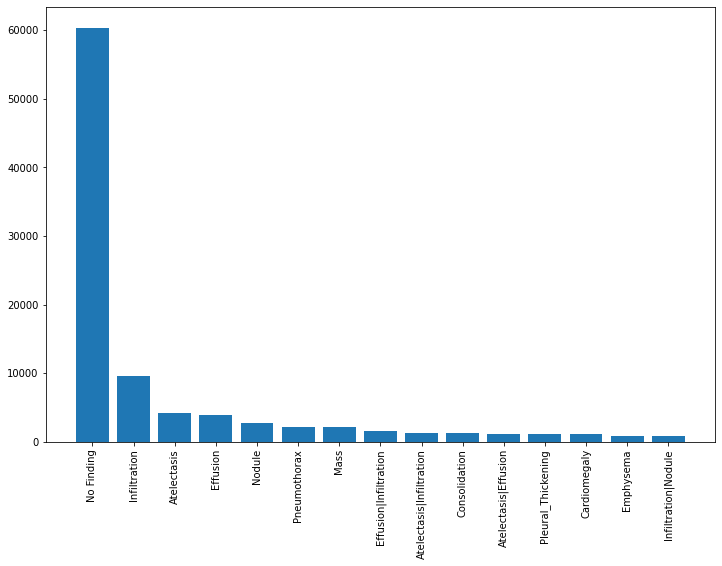

In [340]:
fig, ax1 = plt.subplots(1,1,figsize = (12, 8))
ax1.bar(np.arange(len(label_counts))+0.5, label_counts)
ax1.set_xticks(np.arange(len(label_counts))+0.5)
_ = ax1.set_xticklabels(label_counts.index, rotation = 90)

# --> One hot encoded labels

In [341]:
n_label_list = np.arange(N_LABELS)
ONE_HOT_LABELS = []
for index, label in enumerate(LABELS):
    one_hot_label = []
    for i in range(N_LABELS):
        if n_label_list[index] == i:
            one_hot_label.append(1)
        else:
            one_hot_label.append(0)
    print(one_hot_label)
    ONE_HOT_LABELS.append(one_hot_label)
print(n_label_list)
print(LABELS)

[1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0]
[0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0]
[0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0]
[0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0]
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0]
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0]
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0]
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0]
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1]
[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14]
['Cardiomegaly', 'Emphysema', 'Effusion', 'No Finding', 'Hernia', 'Infiltration', 'Mass', 'Nodule', 'Atelectasis', 'Pneumothorax', 'Pleural_Thickening', 'Pneumonia', 'Fibrosis', 'Edema', 'Consolidation']


# --> Dropping some columns to make it simpler

In [342]:
data_entry_df.drop(columns=["Patient ID", "Follow-up #", "Unnamed: 11"], inplace=True) #Some of those features are important but they need some feature engeneering so they will be implemented later

In [343]:
data_entry_df

,Image Index,Finding Labels,Patient Age,Patient Gender,View Position,OriginalImage[Width,Height],OriginalImagePixelSpacing[x,y],path,...,Effusion,Emphysema,Fibrosis,Hernia,Infiltration,Mass,Nodule,Pleural_Thickening,Pneumonia,Pneumothorax
0,00000001_000.png,Cardiomegaly,58,M,PA,2682,2749,0.143,0.143,../input/data/images_001/images/00000001_000.png,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,00000001_001.png,Cardiomegaly|Emphysema,58,M,PA,2894,2729,0.143,0.143,../input/data/images_001/images/00000001_001.png,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,00000001_002.png,Cardiomegaly|Effusion,58,M,PA,2500,2048,0.168,0.168,../input/data/images_001/images/00000001_002.png,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,00000002_000.png,,81,M,PA,2500,2048,0.171,0.171,../input/data/images_001/images/00000002_000.png,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,00000003_000.png,Hernia,81,F,PA,2582,2991,0.143,0.143,../input/data/images_001/images/00000003_000.png,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
112115,00030801_001.png,Mass|Pneumonia,39,M,PA,2048,2500,0.168,0.168,../input/data/images_012/images/00030801_001.png,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0
112116,00030802_000.png,,29,M,PA,2048,2500,0.168,0.168,../input/data/images_012/images/00030802_000.png,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
112117,00030803_000.png,,42,F,PA,2048,2500,0.168,0.168,../input/data/images_012/images/00030803_000.png,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
112118,00030804_000.png,,30,F,PA,2048,2500,0.168,0.168,../input/data/images_012/images/00030804_000.png,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


# Preprocess images for the CNN model 

# --> Create disease row

In [344]:
data_entry_df["disease_vec"] = data_entry_df.apply(lambda x: [x[all_labels].values], 1).map(lambda x: x[0])

# --> Splitting training and validation dataset

In [345]:
train_df, valid_df = train_test_split(data_entry_df, 
                                   test_size = VALID_SET_PERCENT, 
                                   stratify = data_entry_df["Finding Labels"].map(lambda x: x[:4]))
print("train :", train_df.shape[0], ", validation :", valid_df.shape[0])

train : 89696 , validation : 22424


## --> Data Augmentation 

In [346]:
core_idg = ImageDataGenerator(samplewise_center=True, 
                              samplewise_std_normalization=True, 
                              horizontal_flip = True, 
                              vertical_flip = False, 
                              height_shift_range= 0.05, 
                              width_shift_range=0.1, 
                              rotation_range=5, 
                              shear_range = 0.1,
                              fill_mode = "reflect",
                              zoom_range=0.15)

In [347]:
def flow_from_dataframe(img_data_gen, in_df, path_col, y_col, **dflow_args):
    base_dir = os.path.dirname(in_df[path_col].values[0])
    print("## Ignore next message from keras, values are replaced anyways")
    df_gen = img_data_gen.flow_from_directory(base_dir, 
                                     class_mode = "sparse",
                                    **dflow_args)
    df_gen.filenames = in_df[path_col].values
    df_gen.classes = np.stack(in_df[y_col].values)
    df_gen.samples = in_df.shape[0]
    df_gen.n = in_df.shape[0]
    df_gen._set_index_array()
    df_gen.directory = "" # since we have the full path
    print("Reinserting dataframe: {} images".format(in_df.shape[0]))
    return df_gen

In [348]:
train_gen = flow_from_dataframe(core_idg, train_df, 
                                path_col = "path",
                                y_col = "disease_vec",
                                target_size = IMG_SIZE,
                                color_mode = "grayscale",
                                batch_size = 32)

valid_gen = flow_from_dataframe(core_idg, valid_df, 
                                path_col = "path",
                                y_col = "disease_vec", 
                                target_size = IMG_SIZE,
                                color_mode = "grayscale",
                                batch_size = 256) 

# test_X, test_Y = next(flow_from_dataframe(core_idg, 
#                                           valid_df, 
#                                           path_col = "path",
#                                           y_col = "disease_vec", 
#                                           target_size = IMG_SIZE,
#                                           color_mode = "grayscale",
#                                           batch_size = 1024)) 

## Ignore next message from keras, values are replaced anyways
Found 0 images belonging to 0 classes.
Reinserting dataframe: 89696 images
## Ignore next message from keras, values are replaced anyways
Found 0 images belonging to 0 classes.
Reinserting dataframe: 22424 images


## --> Showing images with labels

In [349]:
t_x, t_y = next(train_gen)
fig, m_axs = plt.subplots(4, 4, figsize = (16, 16))
for (c_x, c_y, c_ax) in zip(t_x, t_y, m_axs.flatten()):
    c_ax.imshow(c_x[:,:,0], cmap = "bone", vmin = -1.5, vmax = 1.5)
    c_ax.set_title(", ".join([n_class for n_class, n_score in zip(all_labels, c_y) 
                             if n_score>0.5]))
    c_ax.axis("off")

IndexError: list index out of range